In [1]:
import sys
path = "../../.."
if path not in sys.path:
    sys.path.insert(0, path)

In [2]:
from data_retrieval import lipade_groundtruth
from absolute_path import absolutePath
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import numpy as np
from torchvision import transforms
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

root = "" # os.environ['DSDIR'] + '/HuggingFace_Models/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
corpus = "lipade_groundtruth"
distancePath = "../results/distance/" + corpus + "/"
rawPath = "../results/raw/" + corpus + "/"
weightsPath = "../results/weights/" + corpus + "/"
model_save_path = "clip.pth"
batch_size = 32

/home/samuel-g/.pyenv/versions/3.11.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained(root + "openai/clip-vit-base-patch32").to(device)
torch.save(model.state_dict(), weightsPath + f"pretrained_{model_save_path}")

# Images
x,m,_ = lipade_groundtruth.getDataset(mode="unique")
is_recto = np.array(m[2])
x = np.array(x)[is_recto]

# Captions
captions = m[1]
images_per_captions = {}
images = []
for file,prompt in captions.keys():
    images_per_captions[prompt] = []

for i in range(len(x)):
    f = '/'.join(x[i].split('/')[-2:])
    if (f, prompt) not in captions.keys():
        images.append(x[i])

x = x.tolist()
for im in images:
    x.remove(im)

for prompt in images_per_captions.keys():
    for i in range(len(x)):
        f = '/'.join(x[i].split('/')[-2:])
        images_per_captions[prompt].append(captions[(f, prompt)])

/home/samuel-g/.pyenv/versions/3.11.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/samuel-g/.pyenv/versions/3.11.11/lib/python3.11/site-packages/transformers/modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are

In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, captions):
        self.image_paths = image_paths
        self.captions = captions

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return self.image_paths[idx], self.captions[idx], idx

In [5]:
def semantic_matching_loss(image_embeds, text_embeds, M, tau=0.07):
    image_embeds = F.normalize(image_embeds, dim=-1)
    text_embeds = F.normalize(text_embeds, dim=-1)

    logits = (image_embeds @ text_embeds.T) / tau
    pred_probs = F.log_softmax(logits, dim=-1)

    target_probs = F.softmax(M.to(device), dim=-1)
    loss = -torch.sum(target_probs * pred_probs) / image_embeds.size(0)
    return loss

In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6)

# Caption 1 - "a black and white photo of "

In [7]:
captions = images_per_captions["a black and white photo of "]

train_images, val_images, train_captions, val_captions = train_test_split(
    x, captions, test_size=0.1, random_state=42
)

train_loader = DataLoader(CustomDataset(train_images, train_captions), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(CustomDataset(val_images, val_captions), batch_size=batch_size, shuffle=False)

In [8]:
def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for paths, captions, indices in val_loader:
            images = []
            for path in paths:
                image = Image.open(path).convert("RGB")
                images.append(image)
            captions = list(captions)
            inputs = processor(text=captions, images=images, return_tensors="pt", padding=True, truncation=True)
            inputs = inputs.to(device)
            outputs = model(**inputs)
            image_embeds = outputs.image_embeds
            text_embeds = outputs.text_embeds

            M = torch.eye(len(indices)).float() # Similarity matrix
            
            loss = semantic_matching_loss(image_embeds, text_embeds, M)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss

1: 100%|██████████| 124/124 [12:07<00:00,  5.87s/it]


[Epoch 0, Step 124] Train Loss: 3.2473, Val Loss: 3.4386


2: 100%|██████████| 124/124 [11:58<00:00,  5.79s/it]


[Epoch 1, Step 248] Train Loss: 3.2416, Val Loss: 3.4376


3: 100%|██████████| 124/124 [12:01<00:00,  5.82s/it]


[Epoch 2, Step 372] Train Loss: 3.2374, Val Loss: 3.4372


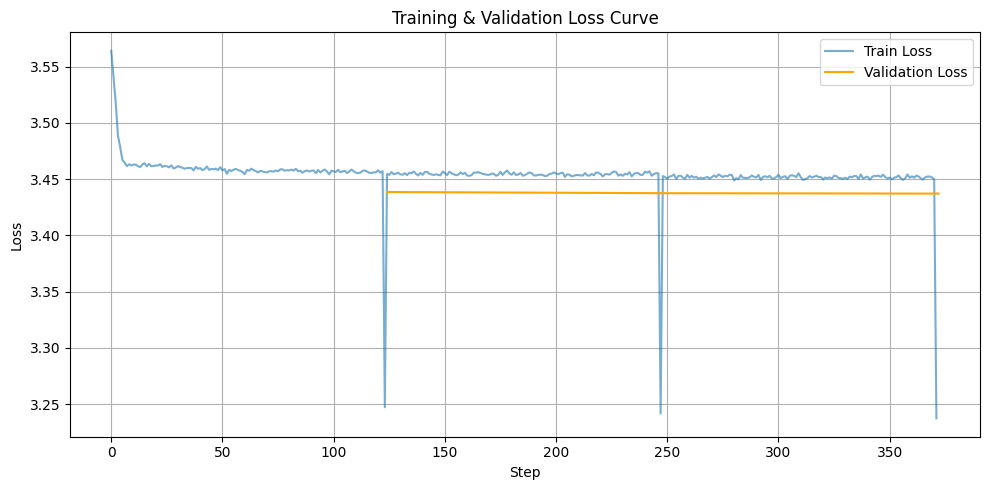

In [9]:
train_losses = []
val_losses = []
train_steps = []
val_steps = []
global_step = 0
eval_interval = 25
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    for batch_id, (paths, captions, indices) in enumerate(tqdm(train_loader, desc=str(epoch+1))):
        images = []
        for path in paths:
            image = Image.open(path).convert("RGB")
            images.append(image)
        captions = list(captions)
        inputs = processor(text=captions, images=images, return_tensors="pt", padding=True, truncation=True)
        inputs = inputs.to(device)
        outputs = model(**inputs)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds

        M = torch.eye(len(indices)).float() # Similarity matrix

        loss = semantic_matching_loss(image_embeds, text_embeds, M)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.item())
        train_steps.append(global_step)
        global_step += 1

    torch.save(model.state_dict(), weightsPath + f"c1_e{epoch}_{model_save_path}")
    val_loss = evaluate_model(model, val_loader)
    val_losses.append(val_loss)
    val_steps.append(global_step)
    print(f"[Epoch {epoch}, Step {global_step}] Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_losses, label='Train Loss', alpha=0.6)
plt.plot(val_steps, val_losses, label='Validation Loss', color='orange')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# TODO : Train the model to have [1, 0, 0, ...] for the first image, [0, 1, 0, ...] for the second image, etc. => Matrice de similarite ???
# https://www.marqo.ai/course/fine-tuning-clip-models
# https://huggingface.co/openai/clip-vit-base-patch32

## 1.1) Train

# Caption 2 - "a newspaper clipping from the early 1900s showing "

In [11]:
captions = images_per_captions["a newspaper clipping from the early 1900s showing "]

## 1.1) Train

# Captions 1&2